In [1]:
# 75.06 - 1C202 - TP2 
# Competencia de Machine learning
#
# https://www.kaggle.com/c/nlp-getting-started/overview
#
# Fuentes:
# https://realpython.com/python-keras-text-classification/
# https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28

# Importacion de librerias necesarias
import re, string, random
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLTK
# https://www.nltk.org
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 

# NLPAUG
# https://github.com/makcedward/nlpaug
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

# Split y K-Fold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Importacion de Keras
# https://keras.io
from keras.models import Sequential, save_model, load_model
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Configuracion general
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pato\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [47]:
# Seccion de CONFIGURACION

# Path de entrada
train_path = 'data/train.csv'
test_path = 'data/test.csv'

# Configuracion del modelo
maxlen = 100
num_filters = 32
kernel_size = 8
embedding_dim = 200
embeddings_path = 'embeddings/glove.twitter.27B.200d.txt'
# Embeddings disponibles en:
# https://worksheets.codalab.org/bundles/0x4090ba96b8a444c2a44b2c47884c25f2



# Path de para guardar los modelos
model_path = 'models/TP2.Keras.Conv1D.Iter.'

# Path de salida para el submission
#submission_path = 'data/submits/submission_01_20200730.csv'

# Funciones AUXILIARES

# Pasa un texto a lowercase
def lowercase_text(text):
    return text.lower()

# Limpia los datos, mediante el uso de expresiones regulares
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Grafica para un modelo los resultados del entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Entrenamiento')
    plt.plot(x, val_acc, 'r', label='Validación')
    plt.title('Accuracy: validación y entrenamiento')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Entrenamiento')
    plt.plot(x, val_loss, 'r', label='Validación')
    plt.title('Loss: validación y entrenamiento')
    plt.legend()
    plt.show()

# Genera la matriz de embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # 0 es un indice reservado, sumamos 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

# Define el modelo a utilizar, con Conv1D
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Carga de los archivos del set de datos

# Set de train: carga, descarte de columnas no utilizadas y limpieza de los textos
df_twitter_train = pd.read_csv(train_path, sep=',')
#Sumo los keywords al text
df_twitter_train['keyword'].fillna(' ', inplace=True)
#df_twitter_train['text'] = (df_twitter_train['text'] + ' ' + df_twitter_train['keyword'])
df_twitter_train.drop('location', axis=1, inplace=True)
df_twitter_train['text'] = df_twitter_train['text'].apply(lambda x: lowercase_text(x))
#df_twitter_train['text'] = df_twitter_train['text'].apply(lambda x: remove_noise(x))

# Set de test: carga, descarte de columnas no utilizadas y limpieza de los textos
df_twitter_test = pd.read_csv(test_path, sep=',')
#Sumo los keywords al text
df_twitter_test['keyword'].fillna(' ', inplace=True)
#df_twitter_test['text'] = (df_twitter_test['text'] + ' ' + df_twitter_test['keyword'])
df_twitter_test.drop('location', axis=1, inplace=True)
df_twitter_test['text'] = df_twitter_test['text'].apply(lambda x: lowercase_text(x))
#df_twitter_test['text'] = df_twitter_test['text'].apply(lambda x: remove_noise(x))


stop_words = set(stopwords.words('english'))
#df_twitter_train['text'] =  df_twitter_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
#df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_twitter_train_aug = pd.DataFrame(df_twitter_train)

aug_syn = naw.SynonymAug(aug_src='wordnet')
aug_swp = naw.RandomWordAug(action="swap")
lem = WordNetLemmatizer()
df_twitter_train['text'] =  df_twitter_train['text'].apply(lambda x: ' '.join([lem.lemmatize(word,"v") for word in x.split()]))
df_twitter_test['text'] =  df_twitter_test['text'].apply(lambda x: ' '.join([lem.lemmatize(word,"v") for word in x.split()]))

# Configuracion de entrenamiento
num_folds = 5
epochs = 1
verbose = False
batch_size = 7

In [48]:
# Nos quedamos con X e y para entrenar
tweets = df_twitter_train_aug['text'].values
y = df_twitter_train_aug['target'].values

# Separamos X para el set de test
tweets_predict = df_twitter_test['text'].values
keyword_predict = df_twitter_test['keyword'].values

# Tokenizamos los textos
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweets)

# Convertimos a secuencias
X = tokenizer.texts_to_sequences(tweets)
X_predict = tokenizer.texts_to_sequences(tweets_predict)

# Calculamos el tamaño
vocab_size = len(tokenizer.word_index) + 1  # 0 es un indice reservado, sumamos 1

#PROBAR CON EL TOKENIZADOR DE NTK DE TWITTER

# Paddeamos a maxlen
X = pad_sequences(X, padding='post', maxlen=maxlen)
X_predict = pad_sequences(X_predict, padding='post', maxlen=maxlen)

# Generacion de la matriz de embeddings
embedding_matrix = create_embedding_matrix(embeddings_path,tokenizer.word_index, embedding_dim)

# Vemos que cobertura tenemos con los embeddings utilizados
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Cobertura de vocabulario: ' + str(nonzero_elements / vocab_size))

Cobertura de vocabulario: 0.524001122859549


------------------------------------------------------------------------
Entrenando, fold 1...
Total Folds:  5
Puntaje de entrenamiento para el fold 1: loss de 0.2983819544315338; accuracy de 88.60427141189575%
Puntaje de validación para el fold 1: loss de 0.4262143075466156; accuracy de 81.41825199127197%


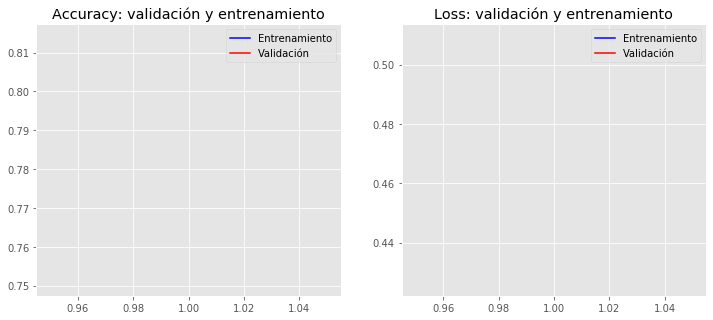

------------------------------------------------------------------------
Entrenando, fold 2...
Total Folds:  5
Puntaje de entrenamiento para el fold 2: loss de 0.3199124336242676; accuracy de 87.81608939170837%
Puntaje de validación para el fold 2: loss de 0.4439954161643982; accuracy de 80.17071485519409%


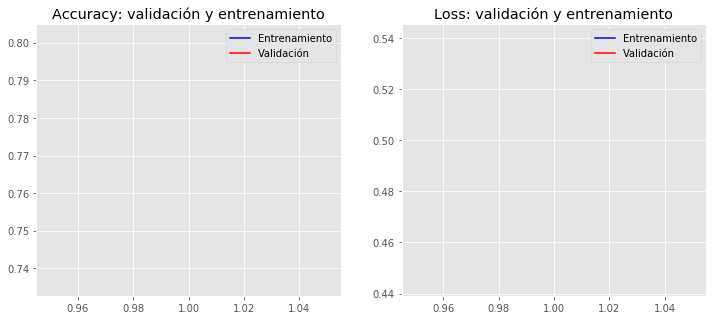

------------------------------------------------------------------------
Entrenando, fold 3...
Total Folds:  5
Puntaje de entrenamiento para el fold 3: loss de 0.3033555746078491; accuracy de 88.98193836212158%
Puntaje de validación para el fold 3: loss de 0.4580751359462738; accuracy de 79.97373342514038%


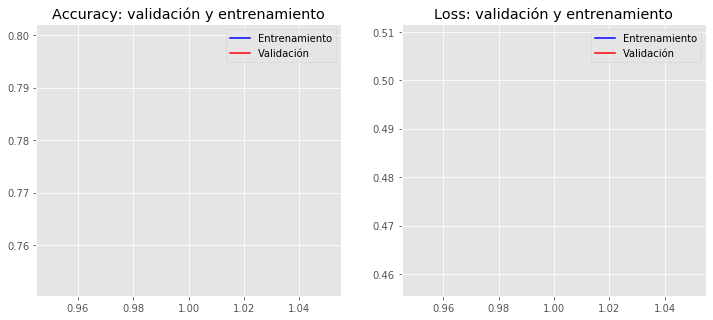

------------------------------------------------------------------------
Entrenando, fold 4...
Total Folds:  5
Puntaje de entrenamiento para el fold 4: loss de 0.29918372631073; accuracy de 88.73748183250427%
Puntaje de validación para el fold 4: loss de 0.45260491967201233; accuracy de 79.10643815994263%


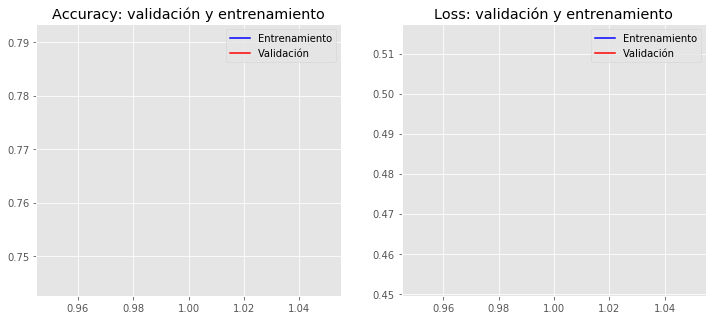

------------------------------------------------------------------------
Entrenando, fold 5...
Total Folds:  5
Puntaje de entrenamiento para el fold 5: loss de 0.3345952332019806; accuracy de 88.22853565216064%
Puntaje de validación para el fold 5: loss de 0.43142592906951904; accuracy de 80.61760663986206%


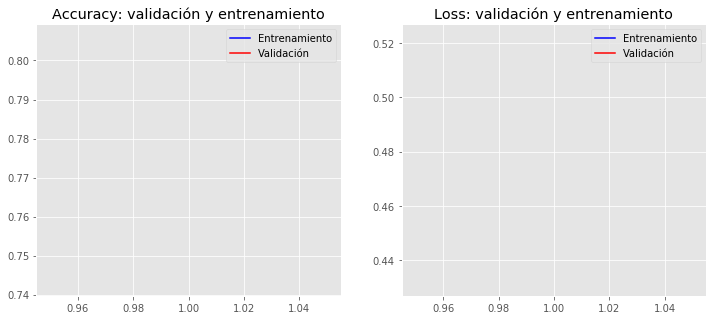



Puntaje promedio de entrenamiendo, para todos los folds:
> Accuracy: 88.47366333007812 (+- 0.40926598792510316)
> Loss: 0.31108578443527224


Puntaje promedio de validación, para todos los folds:
> Accuracy: 80.25734901428223 (+- 0.7602657894886454)
> Loss: 0.4424631416797638
------------------------------------------------------------------------


In [49]:
submission_path = 'data/submits/submission_57_20200801.csv'
# Definimos y entrenamos el modelo
# K-Fold Cross Validation

# Definimos los arrays para guardar los resultados
# Train
acc_per_fold_train = []
loss_per_fold_train = []
# Validacion
acc_per_fold_validation = []
loss_per_fold_validation = []

# Definomos el K-fold Cross Validator a usar
kfold = KFold(n_splits=num_folds, shuffle=True)

# Hacemos el bucle para la cantidad de folds definidos
fold_no = 1
for train, validation in kfold.split(X, y):

    # Imprimimos el progreso
    print('------------------------------------------------------------------------')
    print(f'Entrenando, fold {fold_no}...')
    print('Total Folds: ', num_folds)

    # Definimos la arquitectura del modelo
    model = create_model(num_filters = num_filters,
                         kernel_size = kernel_size,
                         vocab_size = vocab_size,
                         embedding_dim = embedding_dim,
                         maxlen = maxlen)

        # Hacemos el fit
    history = model.fit(X[train], y[train],
                        epochs = epochs,
                        verbose = verbose,
                        validation_data = (X[validation], y[validation]),
                        batch_size = batch_size)      

    # Generamos la metrica de entrenamiento
    scores_train = model.evaluate(X[train], y[train], verbose=0)
    print(f'Puntaje de entrenamiento para el fold {fold_no}: {model.metrics_names[0]} de {scores_train[0]}; {model.metrics_names[1]} de {scores_train[1]*100}%')
    acc_per_fold_train.append(scores_train[1] * 100)
    loss_per_fold_train.append(scores_train[0])

    # Generamos la metrica de test
    scores_validation = model.evaluate(X[validation], y[validation], verbose=0)
    print(f'Puntaje de validación para el fold {fold_no}: {model.metrics_names[0]} de {scores_validation[0]}; {model.metrics_names[1]} de {scores_validation[1]*100}%')
    acc_per_fold_validation.append(scores_validation[1] * 100)
    loss_per_fold_validation.append(scores_validation[0])

    # Guardamos el modelo
    save_model(model, model_path + str(fold_no) + '.h5', save_format='h5')

    # Plotteamos el resultado final
    plot_history(history)

    # Incrementamos el fold
    fold_no = fold_no + 1
    
print('\n')
print('Puntaje promedio de entrenamiendo, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_train)} (+- {np.std(acc_per_fold_train)})')
print(f'> Loss: {np.mean(loss_per_fold_train)}')
print('\n')
print('Puntaje promedio de validación, para todos los folds:')
print(f'> Accuracy: {np.mean(acc_per_fold_validation)} (+- {np.std(acc_per_fold_validation)})')
print(f'> Loss: {np.mean(loss_per_fold_validation)}')
print('------------------------------------------------------------------------')

In [46]:
# Cargamos el modelo con el mejor puntaje
filepath = model_path + str((acc_per_fold_validation.index(max(acc_per_fold_validation)))+1) + '.h5'
loaded_model = load_model(filepath, custom_objects=None, compile=True)

# Prediccion en base al modelo entrenado
y_predict = (loaded_model.predict(X_predict) > 0.5).astype('int32')

# Generacion del dataframe que generara el submit para la competencia
kaggle_submission = pd.DataFrame(df_twitter_test,columns = ['id'])
kaggle_submission['target'] = y_predict

kaggle_submission.to_csv(submission_path, index=False)